In [1]:
import h5py
import numpy as np

with h5py.File("rgb_datasets.h5", "r") as hf:
    X_train_rgb = np.array(hf["X_train_rgb"])
    X_val_rgb = np.array(hf["X_val_rgb"])
    X_test_rgb = np.array(hf["X_test_rgb"])

print(f"Train Set Shape: {X_train_rgb.shape}")
print(f"Validation Set Shape: {X_val_rgb.shape}")
print(f"Test Set Shape: {X_test_rgb.shape}")


Train Set Shape: (12018, 299, 299, 3)
Validation Set Shape: (1502, 299, 299, 3)
Test Set Shape: (1503, 299, 299, 3)


In [12]:
import torch
from transformers import ViTModel, ViTFeatureExtractor
import numpy as np


In [13]:
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

In [14]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

/home/aubct/.local/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [15]:
vit_model.save_pretrained("vit_model")

In [17]:
feature_extractor.save_pretrained("feature_extractor")

['feature_extractor/preprocessor_config.json']

In [16]:
vit_model.eval()

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [5]:
def extract_vit_features(vit_model, feature_extractor, images, batch_size=32):
    vit_features = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vit_model.to(device)

    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]  
        inputs = feature_extractor(batch_images, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = vit_model(**inputs)

        vit_features.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

    return np.concatenate(vit_features, axis=0)

In [6]:
X_train_vit = extract_vit_features(vit_model, feature_extractor, X_train_rgb)
X_val_vit = extract_vit_features(vit_model, feature_extractor, X_val_rgb)
X_test_vit = extract_vit_features(vit_model, feature_extractor, X_test_rgb)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [7]:
import h5py

with h5py.File("vit_features.h5", "w") as f:
    f.create_dataset("X_train", data=X_train_vit)
    f.create_dataset("X_val", data=X_val_vit)
    f.create_dataset("X_test", data=X_test_vit)

print("Features saved in HDF5 format!")

Features saved in HDF5 format!


In [8]:
with h5py.File("vit_features.h5", "r") as f:
    X_train_vit = f["X_train"][:]
    X_val_vit = f["X_val"][:]
    X_test_vit = f["X_test"][:]

print("Extracted features loaded from HDF5!")

Extracted features loaded from HDF5!


In [9]:
print("Train Features Shape:", X_train_vit.shape)
print("Validation Features Shape:", X_val_vit.shape)
print("Test Features Shape:", X_test_vit.shape)

print("Feature Data Type:", X_train_vit.dtype)

Train Features Shape: (12018, 768)
Validation Features Shape: (1502, 768)
Test Features Shape: (1503, 768)
Feature Data Type: float32


In [10]:
import numpy as np

print("First Feature Vector:\n", X_train_vit[5])

print("Min Value:", np.min(X_train_vit))
print("Max Value:", np.max(X_train_vit))


First Feature Vector:
 [ 2.03302190e-01  9.73513499e-02 -2.41526738e-01 -2.58035939e-02
 -1.16951898e-01  2.39602719e-02  1.22704348e-02  1.07797734e-01
  1.39585277e-02 -1.56061813e-01 -2.76799593e-02 -1.28158135e-02
  2.55042583e-01  1.58950001e-01 -1.25794932e-01  2.16929108e-01
  1.12153344e-01 -2.22920343e-01  2.63182342e-01  8.41117501e-02
  2.79361457e-02 -2.10166723e-01 -2.19644621e-01  9.75345150e-02
  1.21267792e-02 -1.40221387e-01  1.68928608e-01  8.90708268e-02
  2.90527977e-02 -1.18497543e-01 -1.74832001e-01  1.20253220e-01
  6.38552383e-02  1.32957876e-01  8.34634353e-04 -8.36434215e-02
 -8.60268772e-02  1.76591845e-03 -1.36866719e-01 -1.76282972e-01
 -2.35820144e-01  5.82491308e-02  1.13135964e-01 -3.35343182e-01
  3.57673205e-02  5.55226766e-02 -2.37397835e-01 -1.09654576e-01
 -6.10678568e-02  3.09053827e-02  2.63431631e-02 -1.56902254e-01
  1.60262674e-01  6.60254508e-02  6.36551455e-02  5.63114397e-02
  1.97907746e-01  5.29245771e-02  7.31034428e-02  1.10486396e-01
  

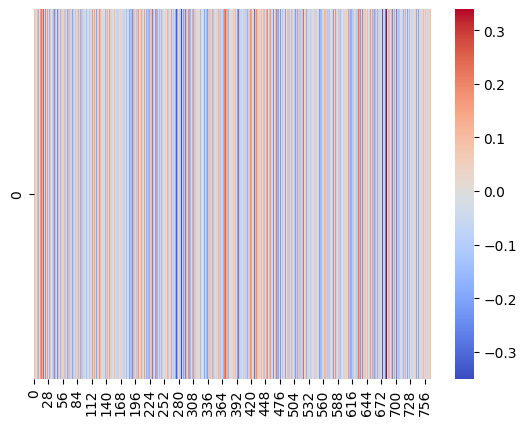

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

reshaped_features = np.expand_dims(X_train_vit[10], axis=0)  
sns.heatmap(reshaped_features, cmap="coolwarm")
plt.show()
